<a href="https://colab.research.google.com/github/malshthunga/Sprint1/blob/main/Sprint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RESOURCES USED

GX Dataset
- https://url.au.m.mimecastprotect.com/s/yl5pCr814vI8o3RkWszhDs4t3Ix?domain=neuralengr.org

- https://github.com/ngebodh/GX_tES_EEG_Physio_Behavior/blob/358804f5b8b47f4753a51fc9990f60d8f37a5b27/examples/GX_tES_Importing_From_MAT.ipynb?utm_source=chatgpt.com


Inspiration
- https://url.au.m.mimecastprotect.com/s/m6n7CyojgDurkmP8pFAuQsxLg3l?domain=neurips.cc


# ADDITIONAL LINKS
 - https://www.kaggle.com/code/malshar/importing-the-gx-dataset-and-analyzing-data-exp-1

- https://www.kaggle.com/code/malshar/importing-set-files-into-mne-and-python-exp-1


## IMPORT LIBRARIES

In [4]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 119.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import mne #EEG library

#from MiSO
# from spike_data_generator import generate_spike_count_data
# from fa_trainer import fit_fa
# from train_data_creator import create_training_data
# from cnn_trainer import train_cnn
# from closed_loop_experiment_executor import run_closed_loop_experiment, visualize_performance

#from .MAT
import matplotlib.pyplot as plt
import seaborn as sns

from math import e
import scipy.io as io
from scipy.signal import butter, sosfiltfilt, welch
import os
try:
    import plotly.express as px
    import plotly.graph_objects as go
except:
    !pip install plotly
    import plotly.express as px
    import plotly.graph_objects as go

try:
    import neurokit2 as nk
except:
    !pip install neurokit2
    import neurokit2 as nk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 44.5 MB/s eta 0:00:00


## STRUCTURE OF THE EEG .MAT FILES (GX DATASET, EXPERIMENT1)
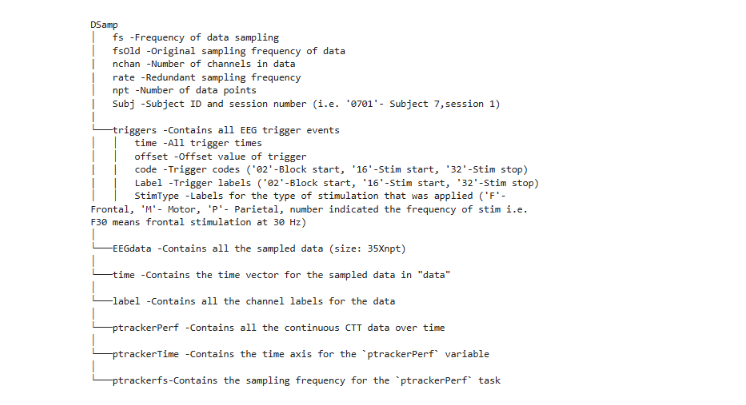


## HELPER FUNCTIONS

from .MAT link

- Additionally, we download the .mat files directly from Zeonodo into the working directory to make our pipeline reproducibile. Hence it can be run without manually downloading it.

 # MOUNT GOOGLE DRIVE AND LOAD EEG DATASET

 - Mount drive, check files to see if exists in Drive if not download them from Zenodo automatically but only once and then in future only need to load the files when run .

In [6]:
#Helper Functions
# ---------------------------------------------------------------------
# Option 1
# -----------------------------------------------------------------------
#  Download EEG datasets directly from Zenodo

# !wget -O EEG_DS_Struct_2302.mat https://zenodo.org/record/3840617/files/EEG_DS_Struct_2302.mat?download=1
# !wget -O EEG_DS_Struct_1901.mat https://zenodo.org/record/3840617/files/EEG_DS_Struct_1901.mat?download=1

# ---------------------------------------------------------------------
# Option 2
# -----------------------------------------------------------------------
# Mount Google Drive
from google.colab import drive
import os, urllib.request

drive.mount('/content/drive')

# Shared dataset folder (create this in your Drive)
shared_folder = "/content/drive/MyDrive/EEG_Project_Datasets"
os.makedirs(shared_folder, exist_ok=True)

# Zenodo base URL + filenames
base_url = "https://zenodo.org/records/3840617/files/"
file_names = ["EEG_DS_Struct_2302.mat", "EEG_DS_Struct_1901.mat"]

def download_if_missing(base_url, file_name, save_dir):
    save_path = os.path.join(save_dir, file_name)
    if not os.path.exists(save_path):
        print(f"Downloading {file_name} ...")
        urllib.request.urlretrieve(base_url + file_name, save_path)
        print(f"Downloaded to {save_path}")
    else:
        print(f"Already exists: {save_path}")

# Run check + download
for f in file_names:
    download_if_missing(base_url, f, shared_folder)


Mounted at /content/drive
Already exists: /content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_2302.mat
Already exists: /content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_1901.mat


# EXPLORATORY DATA ANALYSIS (EDA)


- Quick check of channel labels and raw signals







The below section shows the structures stored inside (DSamp, including EEGdata, label , triggers)

In [7]:
import scipy.io as sio
#load the first dataset
# Choose one dataset (Exp1 for now)
mat_data = sio.loadmat("/content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_2302.mat",
                       squeeze_me=True, struct_as_record=False)

print("Top-level keys:", mat_data.keys())

Top-level keys: dict_keys(['__header__', '__version__', '__globals__', 'DSamp'])


In [8]:
# Access the DSamp struct
DSamp = mat_data['DSamp']

# EEG signals
eeg_data = DSamp.EEGdata    # channels × time
print("EEG data shape:", eeg_data.shape)

# Channel labels
labels = [str(lbl).strip() for lbl in DSamp.label]
print("Number of channels:", len(labels))
print("First 10 channels:", labels[:10])

# Triggers
print(type(DSamp.triggers))
print("First 5 triggers:", DSamp.triggers[0:5])


EEG data shape: (35, 4247524)
Number of channels: 35
First 10 channels: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1']
<class 'numpy.ndarray'>
First 5 triggers: [<scipy.io.matlab._mio5_params.mat_struct object at 0x78e7558995b0>


In [14]:
# Helper function
def load_eeg_dataset(file_path):
    mat = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)
    X = mat['DSamp']

    eeg_data = X.EEGdata
    fs = int(X.fs)  # sampling frequency
    labels = [str(l).strip() for l in X.label.squeeze()]
    triggers = X.triggers if hasattr(X, 'triggers') else None

    return eeg_data, labels, fs, triggers


# Bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')
    return sosfiltfilt(sos, data, axis=1)


# Example usage
file_paths = [
    "/content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_2302.mat",
    "/content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_1901.mat"
]

datasets = {}
for fp in file_paths:
    eeg_data, labels, fs, triggers = load_eeg_dataset(fp)  #  4 values unpacked
    datasets[fp] = {"eeg": eeg_data, "labels": labels, "fs": fs, "triggers": triggers}
    print(f"Loaded {fp}: shape={eeg_data.shape}, fs={fs}, channels={len(labels)}")


Loaded /content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_2302.mat: shape=(35, 4247524), fs=1000, channels=35
Loaded /content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_1901.mat: shape=(35, 4255662), fs=1000, channels=35


Files:
1.Participant 19 - Session 01
  - 35 channels
  - 4,247,524 samples per channe
  - 70.8 minutes of recording (1000 Hz is 4247 seconds)

2.Participant 23 - Session 02

  - 35 channels
  - 4,255,662 samples per channel
  - 71 minutes ( at 1000 Hz  is 4255 seconds)


  Both files have the sampling frequency , same number of channels and same duration of 71 minutes each.

  This makes them directly comparable.

## LOOKING AT FILE CONTENTS AND TRIGGERS (.MAT)

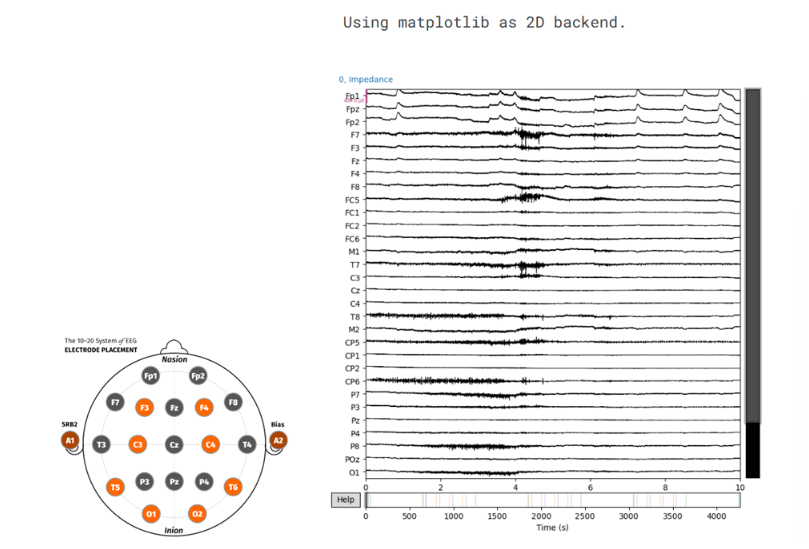

(https://github.com/ngebodh/GX_tES_EEG_Physio_Behavior/blob/358804f5b8b47f4753a51fc9990f60d8f37a5b27/examples/GX_tES_Importing_From_SET.ipynb)


Here we inspect the contents of the `.mat` files:
- Look at the DSamp structure
- Check sampling frequency
- Confirm channel labels
- Inspect shape of raw EEG data
- Look for available triggers

In [16]:
def explore_eeg_file(file_path):
    mat = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)
    X = mat['DSamp']

    eeg_data = X.EEGdata
    fs = int(X.fs)
    labels = [str(l).strip() for l in X.label.squeeze()]
    triggers = X.triggers if hasattr(X, "triggers") else None

    print(f"\n=== {file_path.split('/')[-1]} ===")
    print("Shape (channels × samples):", eeg_data.shape)
    print("Sampling frequency (Hz):", fs)
    print("First 10 channel labels:", labels[:10])
    print("Number of channels:", len(labels))
    print("Type of triggers:", type(triggers))

    return eeg_data, labels, fs, triggers

# Run EDA on both files
file_paths = [
    "/content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_2302.mat",
    "/content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_1901.mat"
]

datasets = {}
for fp in file_paths:
    eeg, labels, fs, triggers = explore_eeg_file(fp)
    datasets[fp] = {"eeg": eeg, "labels": labels, "fs": fs, "triggers": triggers}




=== EEG_DS_Struct_2302.mat ===
Shape (channels × samples): (35, 4247524)
Sampling frequency (Hz): 1000
First 10 channel labels: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1']
Number of channels: 35
Type of triggers: <class 'numpy.ndarray'>

=== EEG_DS_Struct_1901.mat ===
Shape (channels × samples): (35, 4255662)
Sampling frequency (Hz): 1000
First 10 channel labels: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1']
Number of channels: 35
Type of triggers: <class 'numpy.ndarray'>


That means every trigger object has fields like:

    Label → descriptive name (e.g., "stimstart", "stimstop", "blockstart")

    StimType → type of stimulation (if used)

    code → numeric code for the event

    offset → relative offset

    time → timestamp (sample index or seconds)

    type → event type

This will help segment the EEG into epochs.

In [20]:
def extract_stim_events(X, fs=1000):
    events = []
    for trig in X.triggers:
        code = int(getattr(trig, "code", -1))
        if code in [16, 32]:  # 16 = stim start, 32 = stim stop
            events.append({
                "code": code,
                "time_s": float(getattr(trig, "time", np.nan)),
                "sample_index": int(getattr(trig, "time", 0) * fs)
            })
    return pd.DataFrame(events)

triggers_df = extract_stim_events(DSamp, fs=1000)
print(triggers_df)

    code    time_s  sample_index
0     16  1207.876       1207876
1     32  1243.122       1243122
2     16  1357.882       1357882
3     32  1392.961       1392961
4     16  1507.928       1507928
5     32  1543.020       1543020
6     16  1657.872       1657872
7     32  1693.043       1693043
8     16  1807.869       1807869
9     32  1843.008       1843008
10    16  1957.873       1957873
11    32  1993.002       1993002
12    16  2107.987       2107987
13    32  2143.036       2143036
14    16  2257.932       2257932
15    32  2293.096       2293096
16    16  2407.908       2407908
17    32  2443.075       2443075
18    16  2557.902       2557902
19    32  2593.010       2593010
20    16  2707.869       2707869
21    32  2743.091       2743091
22    16  2857.953       2857953
23    32  2893.050       2893050
24    16  3007.921       3007921
25    32  3042.966       3042966
26    16  3157.909       3157909
27    32  3192.997       3192997
28    16  3307.947       3307947
29    32  

__Extracted stimulation events from DSamp__

Columns:
  - code         → event code (16 = stimulation start, 32 = stimulation stop)
  - time_s       → event time in seconds (relative to recording start)
  - sample_index → event time in samples (useful for indexing into EEG data)

Notes:
- Events occur in alternating pairs (16 followed by 32).
- Each pair marks one stimulation period:
      16 = stim ON, 32 = stim OFF.
- These will later be used to segment EEG into pre-stimulation, during-stimulation, and post-stimulation epochs.
- The sample_index column ensures exact alignment with EEG signals (fs = 1000 Hz).


This step helps us confirm that the EEG data structure matches expectations
(channels × time), and lets us preview raw amplitudes before preprocessing.

In [ ]:
## OPTIONAL: Quick peek at raw signal values (for sanity check)
# Helps confirm channel selection and data shape
# subset = eeg_data[chan_indices, 0:10]   # First 10 samples
# print("Subset shape:", subset.shape)    # Should be (5, 10)
# print("Preview:\n", subset)

## EXTRACT TRIGGERS TO DATAFRAME

The triggers mark important events in the EEG timeline:

- **Code 2 (Block Start)** → start of a new block (before stimulation)  
- **Code 16 (Stim Start)** → stimulation begins  
- **Code 32 (Stim Stop)** → stimulation ends  

We will use these events to epoch the EEG around stimulation periods, focusing on the selected channels (`Fp1, Fp2, F3, F4, Fz`).  

This allows us to compute metrics such as **alpha power** and assess how stimulation affects brain activity.


   code    time_s  sample_index  event_name
0    16  1207.876       1207876  Stim Start
1    32  1243.122       1243122   Stim Stop
2    16  1357.882       1357882  Stim Start
3    32  1392.961       1392961   Stim Stop
4    16  1507.928       1507928  Stim Start
5    32  1543.020       1543020   Stim Stop
6    16  1657.872       1657872  Stim Start
7    32  1693.043       1693043   Stim Stop
8    16  1807.869       1807869  Stim Start
9    32  1843.008       1843008   Stim Stop
event_name
Stim Stop     21
Stim Start    20
Name: count, dtype: int64
Recording duration (s): 4255.662
First event at (s): 1207.876
Last event at (s): 4239.456


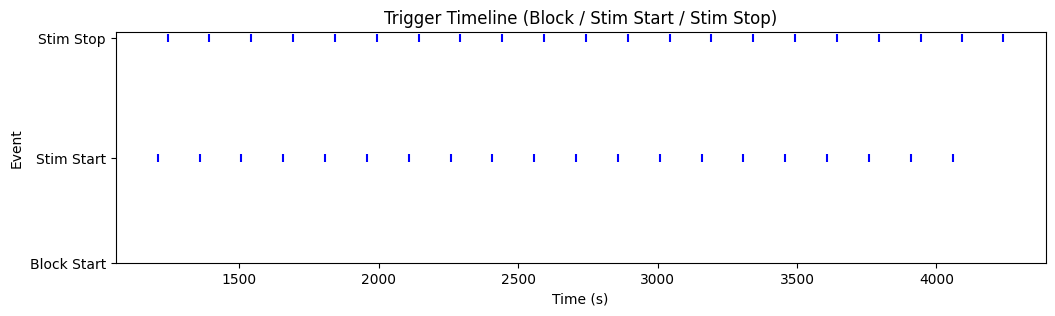

In [21]:
# === Preview Trigger Data ===
# Map event codes to readable names
code_map = {2: "Block Start", 16: "Stim Start", 32: "Stim Stop"}
triggers_df['event_name'] = triggers_df['code'].map(code_map)

# Preview the first 10 rows
print(triggers_df.head(10))

# Count how many of each event type
print(triggers_df['event_name'].value_counts())

# === Check recording duration and event timing ===
print("Recording duration (s):", eeg_data.shape[1] / fs)
print("First event at (s):", triggers_df['time_s'].min())
print("Last event at (s):", triggers_df['time_s'].max())

# === Visualize the trigger timeline ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.scatter(triggers_df['time_s'], triggers_df['code'],
            c='blue', marker='|')

# Replace y-axis codes with labels
plt.yticks([2, 16, 32], ["Block Start", "Stim Start", "Stim Stop"])

plt.xlabel("Time (s)")
plt.ylabel("Event")
plt.title("Trigger Timeline (Block / Stim Start / Stim Stop)")
plt.show()


The EEG dataset contains event markers (triggers) that indicate when key events occurred during the experiment. These include:

__Code 2 (Block Start)__ → marks the beginning of a new block.

__Code 16 (Stim Start)__ → marks when stimulation begins.

__Code 32 (Stim Stop)__ → marks when stimulation ends.

From the DataFrame:

- We observe 20 stimulation starts and 21 stimulation stops, showing that each start is followed by a stop.

- Recording duration is ~71 minutes, with stimulation beginning around 20 minutes into the session and continuing periodically until the end.

The trigger timeline plot confirms this pattern:

- Events are shown along the timeline, with stim start and stim stop alternating across the recording.

- This visualization allows us to clearly identify stimulation periods, which will later be used to extract pre-stimulation, during-stimulation, and post-stimulation EEG segments for analysis.

## EXTRACT DATA fs AND CHANNEL LABELS


**Note:** The original Kaggle example accessed `fs` and labels via MATLAB-style indexing
(e.g. `X['DSamp']['fs'][0][0][0][0]` and truncated to 32 channels to exclude ECG/EOG).  
In our dataset version, all 35 channels are EEG and `fs` is directly available via `DSamp.fs`,
so we keep the cleaner Python version instead.

In [23]:
# Final extraction: these variables are used for analysis.
#Extract EEG signals
# Select only the relevant channels for working memory task
selected_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'FCz']
chan_indices = [labels.index(ch) for ch in selected_channels if ch in labels]

# Extract just these channels
eeg_data_selected = eeg_data[chan_indices, :]
print("Selected EEG shape:", eeg_data_selected.shape)
print("Selected channel labels:", [labels[i] for i in chan_indices])



Selected EEG shape: (5, 4247524)
Selected channel labels: ['Fp1', 'Fp2', 'F3', 'F4', 'Fz']


For our analysis, we focus on a subset of electrodes most relevant for the working memory task (Fp1, Fp2, F3, F4, Fz, FCz). F3 is linked with verbal working memory, while F4 relates to spatial/visual working memory. Fz and FCz are central for working memory processes, whereas Fp1 and Fp2, though informative, may be prone to movement artifacts.

## EXTRACT THE PHYSIO AND CTT DATA

In [25]:
# Pick relevant working memory channels
desired_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'FCz']
selected_channels = [ch for ch in desired_channels if ch in labels]  # keep only existing ones
chan_indices = [labels.index(ch) for ch in selected_channels]

print("Using channels:", selected_channels)

# Plot
import plotly.graph_objects as go
fig = go.Figure()
for ch in selected_channels:
    dat_in = Physio_data[labels.index(ch), start_indx:end_indx]
    dat_in = dat_in - np.mean(dat_in)  # baseline correction
    fig.add_scatter(x=time_in, y=dat_in, mode='lines', name=ch)

fig.update_layout(
    title="EEG Data (First 10 Seconds)",
    xaxis_title="Time (sec)",
    yaxis_title="Amplitude",
    legend_title="Channels"
)
fig.show()


Using channels: ['Fp1', 'Fp2', 'F3', 'F4', 'Fz']


__EEG Data (First 10 Seconds)__

*   This figure shows raw EEG signals from the selected frontal electrodes (Fp1, Fpz, Fp2, F3, F4, Fz) over the first 10 seconds.
*   The signals fluctuate naturally, reflecting ongoing brain electrical activity, while sharp spikes likely represent artifacts such as eye blinks or movement. This confirms the data was imported correctly.

__Although the project specification we highlighted FCz as an important channel, it is not present in this dataset’s channel labels. Therefore, the analysis proceeds with the available electrodes, which still provide strong frontal and midline coverage (Fp1, Fp2, F3, F4, Fz).__



## EXTRACT THE Compensatory Tracking Task (CTT) (behavioral data) AND PLOT
---



In [26]:
# Extract CTT (behavioral) data
CTT_data = np.squeeze(DSamp.ptrackerPerf)   # performance tracking signal
print("CTT data shape:", CTT_data.shape)

# Sampling rate for CTT
fs_ctt = int(DSamp.ptrackerfs)   # usually 100 Hz
print("CTT sampling rate:", fs_ctt)

# Select a 10-second window
start_time = 0
end_time = 10
start_indx = fs_ctt * start_time
end_indx   = fs_ctt * end_time
time_in = np.arange(start_indx, end_indx) / fs_ctt

# Plot behavioral signal
import plotly.graph_objects as go
fig = go.Figure()
dat_in = CTT_data[start_indx:end_indx]
fig.add_scatter(x=time_in, y=dat_in, mode='lines', name="CTT performance")

fig.update_layout(
    title="CTT Data (First 10 Seconds)",
    xaxis_title="Time (sec)",
    yaxis_title="Performance",
    legend_title="Behavior"
)
fig.show()


CTT data shape: (420002,)
CTT sampling rate: 100


__Compensatory Tracking Task(CTT) Data (First 10 Seconds)__

The figure above shows behavioral performance from the Compensatory Tracking Task (CTT) over the first 10 seconds of the session.

- **X-axis:** Time in seconds (0–10 s).  
- **Y-axis:** Task performance (higher values = greater deviation from the target).  
- **Trace (blue line):** In a CTT, participants are required to continuously control a cursor to keep it aligned with a moving target. Performance is measured as deviation from the target position.

**Observations:**
- The signal fluctuates as the participant attempts to maintain accuracy.

- Periods of higher peaks indicate larger tracking errors, while lower values suggest more accurate performance.

- These short-term fluctuations reflect cognitive load and motor control effort, making CTT a useful proxy for working memory and attention under stimulation conditions.

This behavioral data will later be aligned with EEG events (stim start/stop) to test whether brain stimulation improves tracking accuracy, reduces error variability, or introduces disruptions.

(Reference: [Compensatory Tracking Task - Wikipedia](https://url.au.m.mimecastprotect.com/s/k_95Cq714rS8l6yEVsZfPsEAUFe?domain=en.wikipedia.org)
)



## PLOT BOTH PHYSIO AND CTT DATA
Here we will plot both data types.
To do this we will filter by time to get the matching samples in both data types. We need to do this since the Physio data is sampled at `fs = 1000 Hz` and the CTT data is sampled at `fs = 100 Hz`

In [27]:
# Define time window
start_time = 0   # seconds
end_time   = 30  # seconds

# EEG channels of interest
chan_in = ['Fp1', 'Fp2']
chan_indices = [labels.index(ch) for ch in chan_in]

# Get time vectors (direct from DSamp)
eeg_time_in = np.squeeze(DSamp.time)            # EEG time vector (1 kHz)
ctt_time_in = np.squeeze(DSamp.ptrackerTime)    # CTT time vector (100 Hz)

# Extract EEG over selected time window
eeg_indices = np.where((eeg_time_in >= start_time) & (eeg_time_in <= end_time))[0]
eeg_data_in = eeg_data[:, eeg_indices]
eeg_time_plot = eeg_time_in[eeg_indices]

# Extract CTT over same time window
ctt_indices = np.where((ctt_time_in >= start_time) & (ctt_time_in <= end_time))[0]
ctt_data_in = CTT_data[ctt_indices]
ctt_time_plot = ctt_time_in[ctt_indices]

# ---------------------------------------------------------------------------------
# Bandpass filter EEG data (0.5–30 Hz)
lowcut, highcut = 0.5, 30.0
eeg_data_in = bandpass_filter(eeg_data_in, lowcut, highcut, fs)
# ---------------------------------------------------------------------------------

# Plot EEG + CTT
import plotly.graph_objects as go
fig = go.Figure()

# EEG channels
for ch in chan_in:
    dat_in = eeg_data_in[labels.index(ch), :]
    fig.add_scatter(x=eeg_time_plot, y=dat_in, mode='lines', name=ch)

# CTT data
fig.add_scatter(x=ctt_time_plot, y=ctt_data_in, mode='lines', name='CTT', line=dict(color='black'))

# Labels
fig.update_layout(
    title="EEG (Physio) and CTT (Behavior) - First 30 Seconds",
    xaxis_title="Time (sec)",
    yaxis_title="Amplitude / Performance",
    legend_title="Signals"
)

fig.show()


__EEG and CTT Alignment (First 30 Seconds):__

In this step, we plotted both EEG (physiological) data and CTT (behavioral performance) on the same time axis to explore how brain signals relate to task execution.

- Time window: First 30 seconds of the session.
-EEG channels: Fp1 and Fp2 were chosen due to their role in attention and working memory.

- Preprocessing: A bandpass filter (0.5–30 Hz) was applied to clean slow drifts and high-frequency noise.

- CTT data: Shown in black, representing performance fluctuations over time.


__Observations:__

- The EEG traces (Fp1, Fp2) display rhythmic oscillations and several high-amplitude spikes, reflecting ongoing brain activity and possible artifacts.

- The CTT signal changes more slowly, representing variations in task performance.

- Overlaying EEG with CTT highlights how task-related performance may be linked to brain activity patterns, which will be further analyzed around stimulation events (stim start/stop triggers).

## PLOT THE WHOLE SESSION

This figure shows the **entire 70-minute experimental session** with three aligned signals:

- **CTT performance** (blue) – behavioral tracking accuracy over time.  
- **EEG channel (C3)** (red) – raw brain signals, where large voltage shifts correspond to stimulation periods.  
- **Triggers** (green dashed lines) – experimental markers indicating block starts, stim starts, and stim stops.  

By combining all three on the same timeline, we can observe:
- When stimulation occurred in the EEG (voltage offsets).  
- How CTT performance varied across blocks.  
- The alignment between neural, behavioral, and experimental events.  

This gives a **big-picture view of the whole experiment** before zooming in to specific epochs for detailed analysis.

In [28]:
def plot_whole_session(eeg_data, eeg_time, ctt_data, ctt_time,
                       channel_labels, triggers_df, chan_name="C3"):
    """
    Plot EEG (one channel), CTT behavioral data, and triggers across the full session.

    eeg_data       : ndarray (channels × time)
    eeg_time       : ndarray (time points for EEG)
    ctt_data       : ndarray (CTT data)
    ctt_time       : ndarray (time points for CTT)
    channel_labels : list of EEG channel labels
    triggers_df    : DataFrame with trigger events (must include 'time_s')
    chan_name      : string, channel to plot (default = 'C3')
    """

    plt.figure(figsize=(15, 6))

    # Plot CTT behavioral data
    plt.plot(ctt_time, np.squeeze(ctt_data) * 100,
             alpha=0.8, label="Behavioral CTT")

    # Pick EEG channel
    if chan_name not in channel_labels:
        raise ValueError(f"Channel {chan_name} not found in labels {channel_labels[:10]}...")
    chan_idx = channel_labels.index(chan_name)

    dat_in = np.squeeze(eeg_data[chan_idx, :])
    dat_in_max = np.max(dat_in)

    plt.plot(eeg_time, dat_in - np.mean(dat_in),
             alpha=0.5, label=f"EEG {chan_name}")

    # Plot triggers
    if "time_s" in triggers_df.columns:
        triggers_time = triggers_df["time_s"].values
        plt.vlines(triggers_time,
                   ymin=-dat_in_max, ymax=dat_in_max,
                   colors="g", linestyles="--", linewidth=1,
                   alpha=0.5, label="Triggers")

    # Formatting
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude / Performance")
    plt.title(f"Whole Session EEG ({chan_name}), CTT Behavior, and Triggers")
    plt.ylim(np.array([-1.25, 1.25]) * dat_in_max)
    for pos in ["right", "top"]:
        plt.gca().spines[pos].set_visible(False)
    plt.legend()
    plt.show()

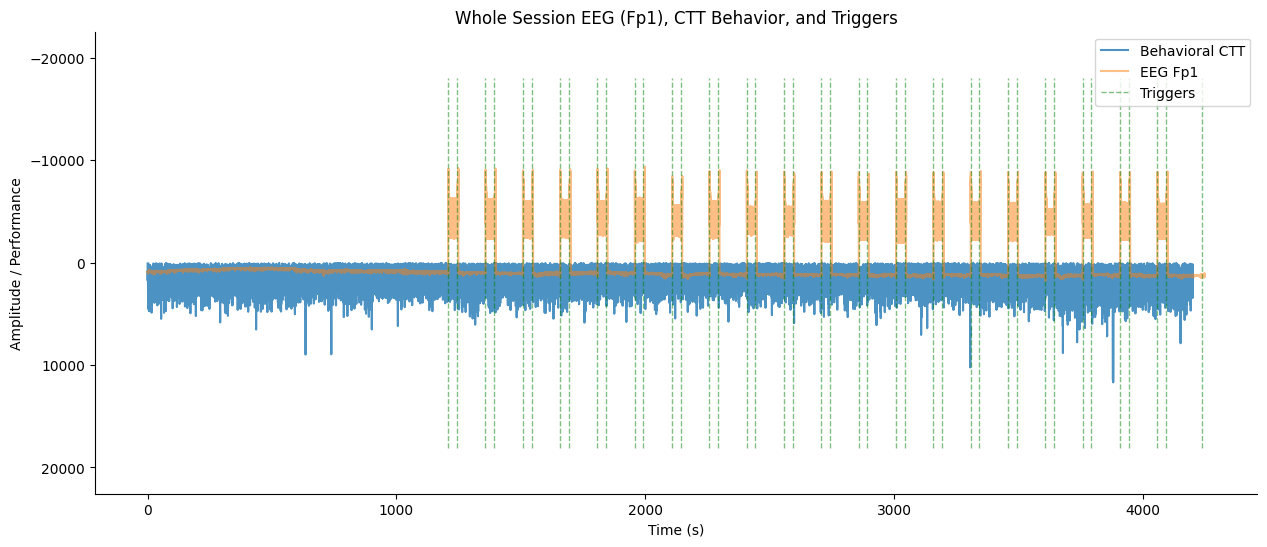

In [29]:
# Make sure channel_labels is set correctly
channel_labels = labels   # from earlier extraction

plot_whole_session(
    eeg_data=Physio_data,
    eeg_time=eeg_time_in,
    ctt_data=CTT_data,
    ctt_time=ctt_time_in,
    channel_labels=channel_labels,
    triggers_df=triggers_df,  # from extract_triggers()
    chan_name="Fp1"            # change to "Fp1", "Fz", "FCz", etc.
)

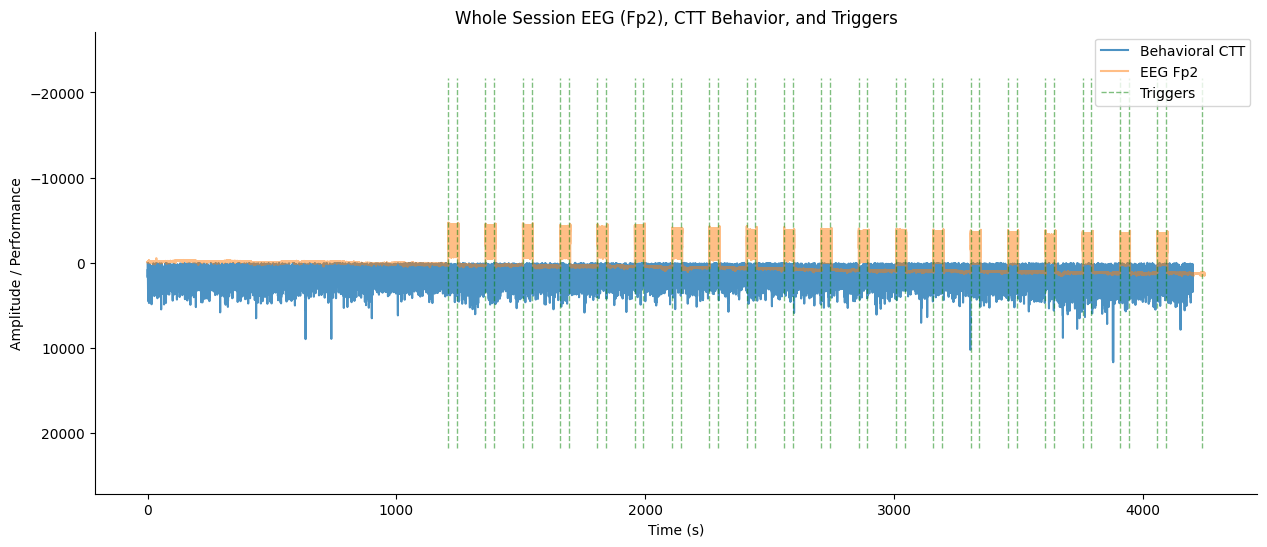

In [30]:
# Make sure channel_labels is set correctly
channel_labels = labels   # from earlier extraction

plot_whole_session(
    eeg_data=Physio_data,
    eeg_time=eeg_time_in,
    ctt_data=CTT_data,
    ctt_time=ctt_time_in,
    channel_labels=channel_labels,
    triggers_df=triggers_df,  # from extract_triggers()
    chan_name="Fp2"            # 👈 change to "Fp1", "Fz", "FCz", etc.
)

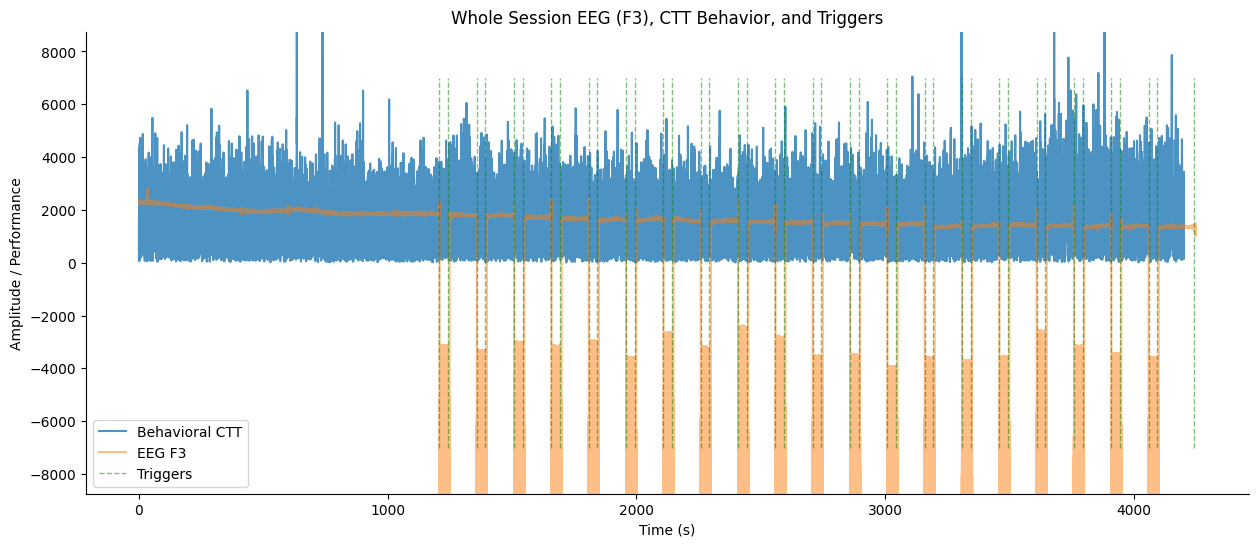

In [31]:
# Make sure channel_labels is set correctly
channel_labels = labels   # from earlier extraction

plot_whole_session(
    eeg_data=Physio_data,
    eeg_time=eeg_time_in,
    ctt_data=CTT_data,
    ctt_time=ctt_time_in,
    channel_labels=channel_labels,
    triggers_df=triggers_df,  # from extract_triggers()
    chan_name="F3"            # 👈 change to "Fp1", "Fz", "FCz", etc.
)

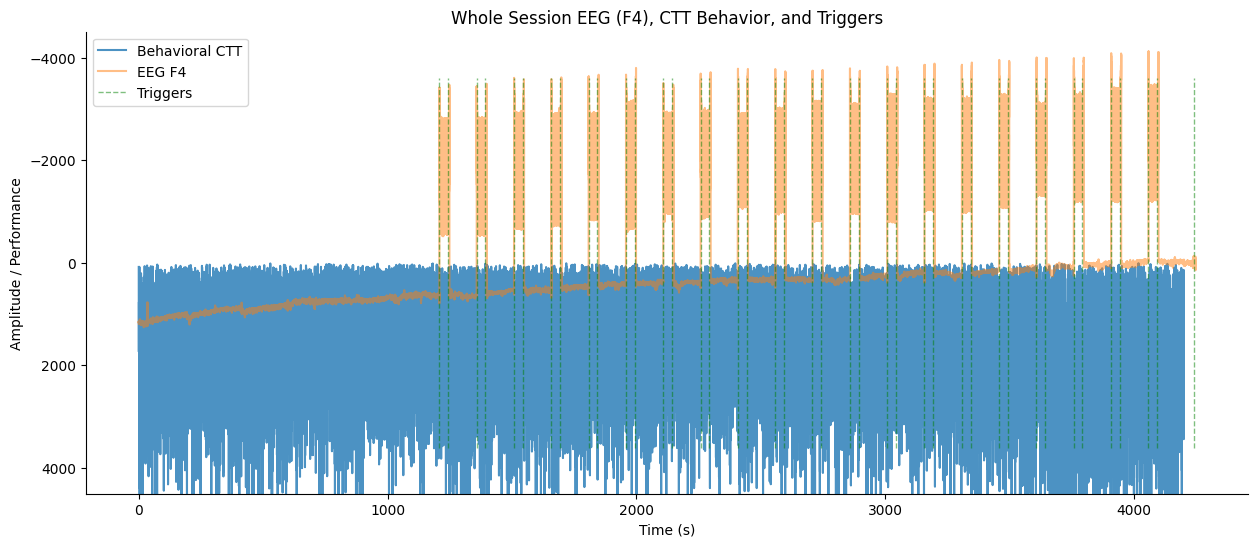

In [32]:
# Make sure channel_labels is set correctly
channel_labels = labels   # from earlier extraction

plot_whole_session(
    eeg_data=Physio_data,
    eeg_time=eeg_time_in,
    ctt_data=CTT_data,
    ctt_time=ctt_time_in,
    channel_labels=channel_labels,
    triggers_df=triggers_df,  # from extract_triggers()
    chan_name="F4"            # 👈 change to "Fp1", "Fz", "FCz", etc.
)

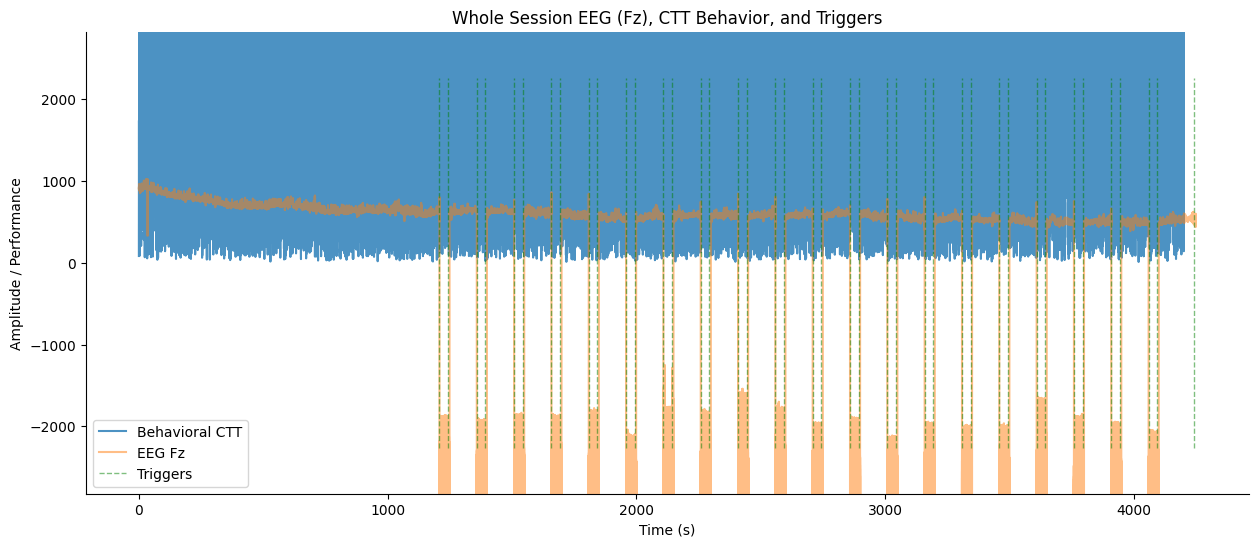

In [33]:
# Make sure channel_labels is set correctly
channel_labels = labels   # from earlier extraction

plot_whole_session(
    eeg_data=Physio_data,
    eeg_time=eeg_time_in,
    ctt_data=CTT_data,
    ctt_time=ctt_time_in,
    channel_labels=channel_labels,
    triggers_df=triggers_df,  # from extract_triggers()
    chan_name="Fz"            # 👈 change to "Fp1", "Fz", "FCz", etc.
)

ValueError: Channel FCz not found in labels ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1']...

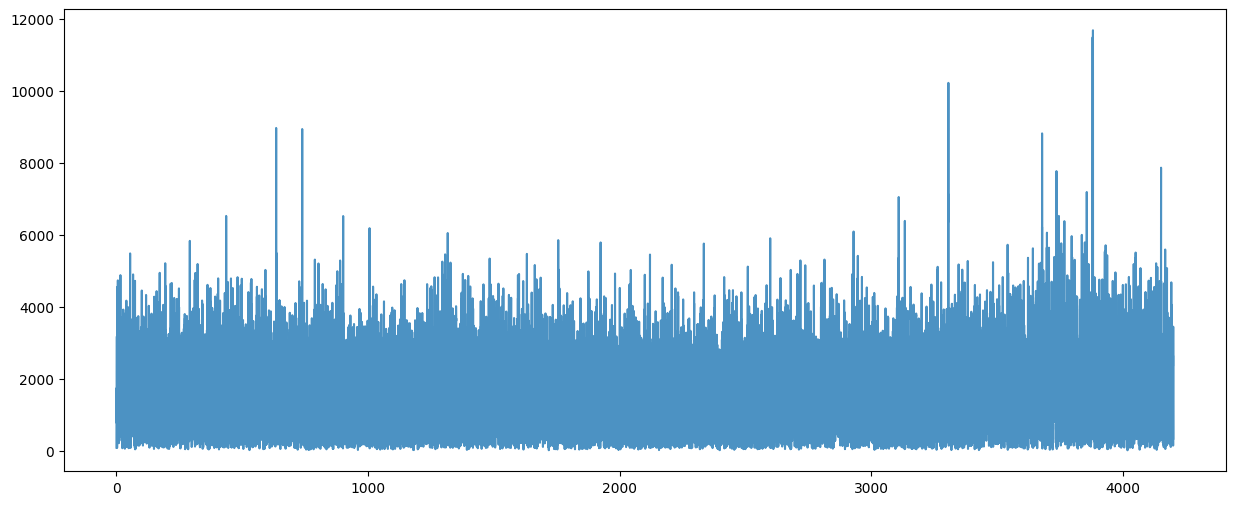

In [34]:
# Make sure channel_labels is set correctly
channel_labels = labels   # from earlier extraction

plot_whole_session(
    eeg_data=Physio_data,
    eeg_time=eeg_time_in,
    ctt_data=CTT_data,
    ctt_time=ctt_time_in,
    channel_labels=channel_labels,
    triggers_df=triggers_df,  # from extract_triggers()
    chan_name="FCz"            # 👈 change to "Fp1", "Fz", "FCz", etc.
)

__OVERALL OBSERVATION : EEG + CTT + Triggers__

1. **EEG signals (Fp1, Fp2, F3, F4, Fz):**  
   - Each graph shows raw EEG activity from one frontal electrode across the entire recording (~70 minutes).  
   - Fluctuations reflect brain electrical activity.
   -  Strong shifts (large positive/negative swings) occur during stimulation blocks.

2. **CTT performance (blue line):**  
   - Tracks how well the subject performed the compensatory tracking task..  
   - Shows variability across time, with rises and falls possibly linked to cognitive load or fatigue.

3. **Triggers (green dashed lines):**  
   - Mark the timing of stim start (16) and stim stop (32) events.
   - Allows to segment EEG into “pre-stim”, “during-stim”, and “post-stim” windows.a.  

4. **Channel Comparison:**  
   - **Fp1 / Fp2 (frontopolar):** Show strong artifact-like fluctuations (common in frontal electrodes, likely eye blinks or movement).
   - **F3, F4:** More stable baseline with visible responses during stim periods.
→ Matches Farwa’s note: F3 linked to verbal working memory, F4 to spatial/visual working memory.

  - **Fz:**Clearer representation of stimulation blocks, important for central frontal monitoring.

Some channels **(e.g., FCz)** may not exist in this dataset, which is normal depending on the session recording setup.  


__The plots confirm that stimulation events strongly modulate EEG activity at frontal sites, while also influencing task performance (CTT). The dataset is now ready for **epoch extraction** and **feature analysis** (e.g., alpha/beta power changes) to study stimulation effects.__


## ONE TRIAL

these are triggers that start the stimulation and initiate the stimulation ramp up

In [36]:
# Pull out the stim start triggers
triggers_stimstart = triggers_df[triggers_df['event_name'] == "Stim Start"].copy()

# Reset the index
triggers_stimstart.reset_index(drop=True, inplace=True)

# Show first few rows
triggers_stimstart.head()






code    time_s  sample_index  event_name
0    16  1207.876       1207876  Stim Start
1    16  1357.882       1357882  Stim Start
2    16  1507.928       1507928  Stim Start
3    16  1657.872       1657872  Stim Start
4    16  1807.869       1807869  Stim Start



*  The table shows all stimulation start events (code 16).
*  time_s → when the stimulation began in seconds since recording started.
*  sample_index → the exact data sample corresponding to that start (useful for indexing EEG).
*  event_name confirms these are only "Stim Start" triggers.
* These timepoints will later be used to extract EEG epochs before, during, and after stimulation.



## STIM STOP TRIGGERS

these triggers that stop the stimulation and initate the stimulation ramp down.

please note that there is some -600ms delay in voltage rebound after the  sec ramp down

In [38]:
# Pull out the stim stop triggers
triggers_stimstop = triggers_df[triggers_df['event_name'] == "Stim Stop"].copy()

# keep only times
ii = triggers_stimstop['time_s'].tolist()

# reset index
triggers_stimstop.reset_index(drop=True, inplace=True)

# assign cleaned time column
triggers_stimstop = triggers_stimstop.assign(time=ii)

# preview
triggers_stimstop.head()



code    time_s  sample_index event_name      time
0    32  1243.122       1243122  Stim Stop  1243.122
1    32  1392.961       1392961  Stim Stop  1392.961
2    32  1543.020       1543020  Stim Stop  1543.020
3    32  1693.043       1693043  Stim Stop  1693.043
4    32  1843.008       1843008  Stim Stop  1843.008

__One Trial (Pre → During → Post Stimulation)__

-This step extracts the __stimulation stop events__ (Stim Stop) from the trigger log.

- Each row shows the exact time (in seconds), sample index, and event name where stimulation was stopped.

- These triggers mark when the system initiates the ramp-down phase of stimulation.

- Note: there is typically a small delay (~600 ms) in the EEG signal after each stop event, due to voltage rebound effects.

This will later be paired with Stim Start events to define the full stimulation intervals.

# TRIGGERS

we will plot one whole trial , this is pre -> during -> post stimulation periods.

In [41]:
# Reload dataset
file_path = "/content/drive/MyDrive/EEG_Project_Datasets/EEG_DS_Struct_2302.mat"
mat = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)
X = mat['DSamp']

# Define times for trial segments
time_before_trig = 30
time_ramp_up = 5
time_stim_on = 30
time_ramp_down = 5
time_after_trig = 30

# Trial window (based on stim triggers)
trial_start = triggers_stimstart.iloc[0]['time_s'] - time_before_trig
trial_end   = triggers_stimstop.iloc[0]['time_s'] + time_ramp_down + time_after_trig


# Define time vectors
eeg_time_in = X.time
ctt_time_in = X.ptrackerTime

# EEG slice
eeg_indices = np.where((eeg_time_in >= trial_start) & (eeg_time_in <= trial_end))[0]
eeg_data_in = Physio_data[:, eeg_indices]
eeg_time_plot = eeg_time_in[eeg_indices]

# CTT slice
ctt_indices = np.where((ctt_time_in >= trial_start) & (ctt_time_in <= trial_end))[0]
ctt_data_in = CTT_data[ctt_indices]
ctt_time_plot = ctt_time_in[ctt_indices]

print("Trial window:", trial_start, "to", trial_end)

# Channel selection (check Fz exists)
chan_in = ['Fz']
for chan in chan_in:
    if chan in channel_labels:
        dat_in = eeg_data_in[channel_labels.index(chan), :]
        dat_in = dat_in - np.mean(dat_in)  # baseline correction
        fig = go.Figure()
        fig.add_scatter(x=eeg_time_plot, y=dat_in, mode='lines', name=chan)

# Add CTT
fig.add_scatter(x=ctt_time_plot, y=ctt_data_in*100, mode='lines', name="CTT")

# Layout
fig.update_layout(
    title="Single Trial EEG (Fz) + CTT",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude / Performance",
    legend_title="Signals"
)
fig.show()


Trial window: 1177.876 to 1278.122


__Single Trial EEG + CTT (Fz channel)__

__X-Axis__:Time in seconds (1177–1278s, i.e., ~100s trial window).

__Y-Axis__:Amplitude of EEG (red, baseline-corrected) and scaled CTT performance (blue)

__Signals__:

- EEG (Fz, red): Shows neural fluctuations. You can see normal oscillations and variability, reflecting ongoing brain activity.

- CTT performance (blue): Shows a flat high–low pattern during the stimulation window. This “block” shape comes from the behavioral tracking signal being scaled and aligned with stimulation.

__Trial Windown__:Covers

- Pre-stimulation baseline (30s before stim),
- Stimulation period (30s on, with 5s ramp-up/down),
- Post-stimulation (30s after).

# EPOCH EXTRACTION

from GX tES EEG :
(https://github.com/ngebodh/GX_tES_EEG_Physio_Behavior/blob/master/GX_PullingDataIntoTrials_PlottingTopoplots.m)

section looking at each stimulation trial




In [42]:
def extract_epochs(eeg_data, triggers_df, fs=1000,
                   prestimulation_time=30, duration_time=30, poststimulation_time=30,
                   during_offset=5, post_offset=35):
    """
    Extract pre-, during-, and post-stimulation epochs from EEG data.

    Parameters
    ----------
    eeg_data : np.array (channels x time)
    triggers_df : DataFrame with 'label' and 'sample_index'
    fs : int (Hz), sampling frequency
    """
    # Get stim start sample indices
    stim_starts = triggers_df[triggers_df['event_name'] == 'Stim Start']['sample_index'].values


    epochs = {"Pre-stimulation": [], "During-stimulation": [], "Post-stimulation": []}

    for t in stim_starts:
        # Pre-stimulation
        start_pre = t - int(prestimulation_time * fs)
        end_pre = t
        if start_pre >= 0:
            epochs["Pre-stimulation"].append(eeg_data[:, start_pre:end_pre])

        # During stimulation
        start_dur = t + int(during_offset * fs)
        end_dur = start_dur + int(duration_time * fs)
        if end_dur <= eeg_data.shape[1]:
            epochs["During-stimulation"].append(eeg_data[:, start_dur:end_dur])

        # Post-stimulation
        start_post = t + int(post_offset * fs)
        end_post = start_post + int(poststimulation_time * fs)
        if end_post <= eeg_data.shape[1]:
            epochs["Post-stimulation"].append(eeg_data[:, start_post:end_post])

    return epochs


In [43]:
# Select channels of interest
target_chans = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz']
chan_indices = [labels.index(ch) for ch in target_chans if ch in labels]
selected_data = eeg_data[chan_indices, :]

# Extract epochs
epochs = extract_epochs(selected_data, triggers_df, fs=1000)

print("Pre-stim epochs:", len(epochs["Pre-stimulation"]))
print("During-stim epochs:", len(epochs["During-stimulation"]))
print("Post-stim epochs:", len(epochs["Post-stimulation"]))
print("Shape of first Pre-stim epoch:", epochs["Pre-stimulation"][0].shape)


Pre-stim epochs: 20
During-stim epochs: 20
Post-stim epochs: 20
Shape of first Pre-stim epoch: (5, 30000)


We extracted EEG epochs around stimulation events.  
Each trial was divided into **three segments**:

- **Pre-stimulation**: 30 seconds before the current ramp up.  
- **During stimulation**: 30 seconds after current reached full intensity (offset by 5 s).  
- **Post-stimulation**: 30 seconds after stimulation ramp down (offset by 35 s).  

- Each epoch corresponds to one stimulation trial.
- The shape of the first pre-stim epoch is (5, 30000):
  - 5 = number of selected EEG channels (Fp1, Fp2, F3, F4, Fz).
  - 30000 = number of time samples in the 30-second window at 1000 Hz sampling frequency.

This confirms that the data was segmented correctly into trial-based windows aligned with the stimulation triggers. These epochs will later be used for averaging, statistical analysis, or time–frequency analysis to compare brain activity before, during, and after stimulation.

# PREPROCESSING (inside each epoch)


In [44]:
#baseline correction
def baseline_correction(epoch, fs=1000, baseline_dur=1):
    baseline_samples = int(baseline_dur * fs)
    baseline = np.mean(epoch[:, :baseline_samples], axis=1, keepdims=True)
    return epoch - baseline

# Apply baseline correction to all epochs
for key in epochs.keys():
    epochs[key] = [baseline_correction(ep, fs=1000) for ep in epochs[key]]

print("Baseline corrected Pre-stim epoch shape:", epochs["Pre-stimulation"][0].shape)


Baseline corrected Pre-stim epoch shape: (5, 30000)


In [45]:
#artifact removal
def reject_artifacts(epoch, threshold=100):
    return np.any(np.abs(epoch) > threshold)

# Example: keep only clean epochs
clean_epochs = {k: [ep for ep in v if not reject_artifacts(ep)]
                for k, v in epochs.items()}

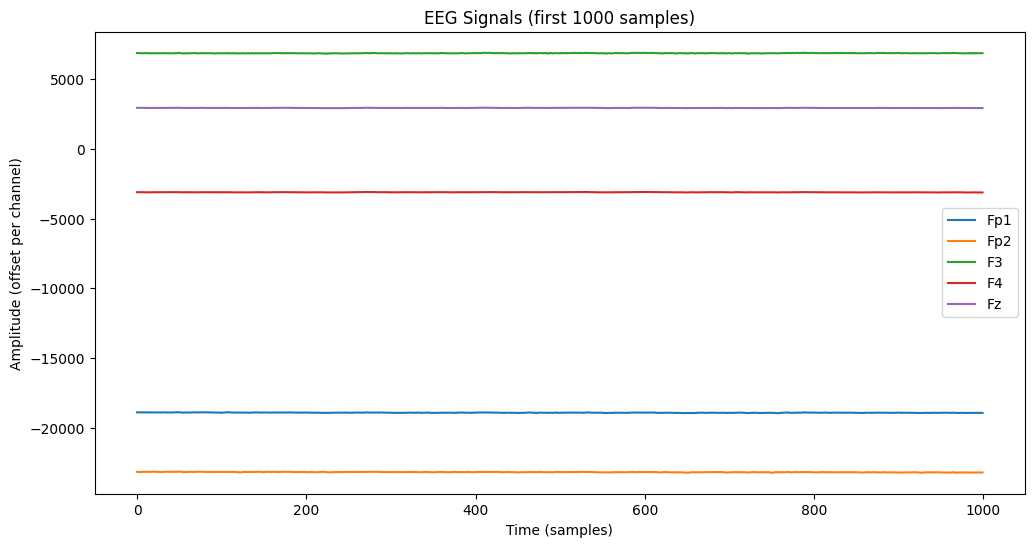

In [47]:
# Example: plot first 1000 samples for all selected channels


selected_labels = [labels[i] for i in chan_indices]

plt.figure(figsize=(12, 6))
for i, ch in enumerate(selected_labels):
    plt.plot(selected_data[i, :1000] + i*200, label=ch)  # offset each channel for clarity
plt.legend()
plt.title("EEG Signals (first 1000 samples)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (offset per channel)")
plt.show()

__X-Axis__:
  - The first 1000 samples at a sampling frequency of 1000 Hz = the first second of data.
__Y-Axis__:
  - EEG amplitude values, shifted up/down so that each channel is visible separately (offset for clarity).
__Interpretation__:
  - The signals are currently raw, unfiltered, so they look almost flat and at very large values (in the tens of thousands).
  - __Baseline drifts__ ( slow fluctuations in the mean voltage)
  - __Large DC Offsets___ (different resting values per electrode)
  - __High frequency noise__ (tiny wiggles hidden in the scale)

__Why it looks flat?__
- Since the amplitude scale is huge (thousands), the meaningful brain activity (µV level) is tiny in comparison.

- Therefore preprocessing (baseline correction, filtering, artifact rejection) is neccesary to a usable range and removes noise/artifacts.

This figure confirms that the EEG channels are being read correctly, but the signals still need filtering and preprocessing before you can interpret brain activity.

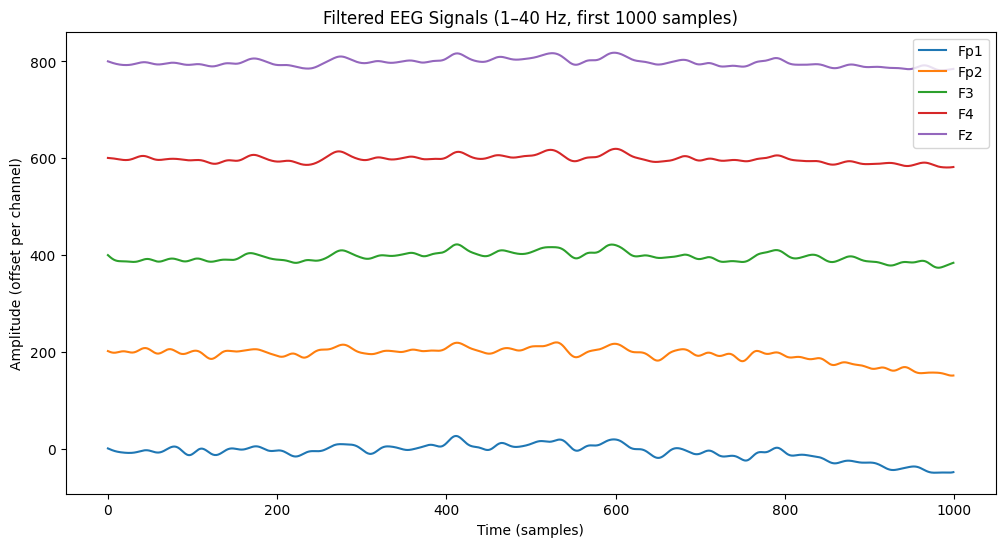

In [48]:
# Apply bandpass filter (1-40 Hz)
fs = 1000
filtered_data = bandpass_filter(selected_data, 1, 40, fs)

# Plot again after filtering
plt.figure(figsize=(12, 6))
for i, ch in enumerate(selected_labels):
    plt.plot(filtered_data[i, :1000] + i*200, label=ch)
plt.legend()
plt.title("Filtered EEG Signals (1–40 Hz, first 1000 samples)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (offset per channel)")
plt.show()

- Channels plotted: Fp1, Fp2, F3, F4, Fz (frontal & central electrodes you selected earlier).
  
- X-axis: Time (first 1000 samples = 1 second, since fs=1000 Hz).
- Y-axis: EEG amplitude (offset per channel for clarity).
- Traces: You now see rhythmic oscillations instead of flat drifts.

__After filtering (1–40 Hz)__:

- the traces show oscillatory activity typical of EEG
- Slow drifts (from sweat, baseline shifts) and fast noise (muscle artifacts, 50/60 Hz line noise) have been removed

__Offsets between channels__:

- Each line is vertically shifted ("offset") so they don’t overlap.
- This doesn’t mean one channel has higher amplitude

__Preserved brain rhythms__:

- The signals now reflect EEG frequency bands (delta, theta, alpha, beta).
- For frontal electrodes (Fp1, Fp2), you might later observe artifacts (eye blinks, eye movements).
- F3, F4, Fz will show working memory task-related activity more clearly.

## pre stimulation analysis to the data

In [76]:
# --- Pre-stimulation EEG (30s before stim) ---

# Define segment times
time_before_trig = 30
trial_start = triggers_stimstart.iloc[0]['time'] - time_before_trig
trial_end   = triggers_stimstart.iloc[0]['time']

# Time vector
eeg_time_in = x['DSamp']['time'][0][0][0][:]
eeg_indices = np.where((eeg_time_in >= trial_start) & (eeg_time_in <= trial_end))[0]

# Extract EEG segment for selected channels
selected_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz']
chan_indices = [channel_labels.index(ch) for ch in selected_channels if ch in channel_labels]

eeg_data_pre = Physio_data[chan_indices, :][:, eeg_indices]
eeg_time_pre = eeg_time_in[eeg_indices]

# Plot EEG for multiple channels
plt.figure(figsize=(12,6))
for i, ch in enumerate(selected_channels):
    plt.plot(eeg_time_pre, eeg_data_pre[i,:] + i*200, label=ch)  # offset each channel by +200

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (offset per channel)")
plt.title("Pre-stimulation EEG (30s window)")
plt.legend()
plt.show()


KeyError: 'time'

## look at Pre stim EEG and plot FFT



In [ ]:
# Apply bandpass filter (0.5–30 Hz)
eeg_data_pre_filt = bandpass_filter(eeg_data_pre, 0.5, 30, fs_eeg)

# Compute PSD for selected channels
df_pre_psd = pd.DataFrame()
for indx, chan in enumerate(selected_channels):
    dat_in = np.squeeze(eeg_data_pre_filt[indx, :])
    psd_welch = nk.signal_psd(dat_in, method="welch", min_frequency=1, show=False)

    # Store frequency axis once
    if indx == 0:
        df_pre_psd['Frequency'] = psd_welch['Frequency']

    # Store channel power
    df_pre_psd[chan] = psd_welch['Power']

# --- Plot PSD ---
fig = go.Figure()
for chan in selected_channels:
    fig.add_scatter(x=df_pre_psd['Frequency'], y=df_pre_psd[chan],
                    mode='lines', name=chan)

fig.update_layout(
    title="Pre-stimulation EEG PSD (Welch method)",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Power (µV²/Hz)",
    legend_title="Channels",
    width=800
)
fig.update_xaxes(range=[0, 30])  # focus on 0–30 Hz
fig.show()

## post stimulation data

In [ ]:
# Apply bandpass filter (0.5–30 Hz)
eeg_data_post_filt = bandpass_filter(eeg_data_post, 0.5, 30, fs_eeg)

# Compute PSD for selected channels
df_post_psd = pd.DataFrame()
for indx, chan in enumerate(selected_channels):
    dat_in = np.squeeze(eeg_data_post_filt[indx, :])
    psd_welch = nk.signal_psd(dat_in, method="welch", min_frequency=1, show=False)

    # Store frequency axis once
    if indx == 0:
        df_post_psd['Frequency'] = psd_welch['Frequency']

    # Store channel power
    df_post_psd[chan] = psd_welch['Power']

# --- Plot PSD ---
fig = go.Figure()
for chan in selected_channels:
    fig.add_scatter(x=df_post_psd['Frequency'], y=df_post_psd[chan],
                    mode='lines', name=chan)

fig.update_layout(
    title="Post-stimulation EEG PSD (Welch method)",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Power (µV²/Hz)",
    legend_title="Channels",
    width=800
)
fig.update_xaxes(range=[0, 30])  # focus on 0–30 Hz
fig.show()

## Look at Post Stim EEG and Plot **FFT**

In [ ]:
# Apply bandpass filter (0.5–30 Hz)
eeg_data_post_filt = bandpass_filter(eeg_data_post, 0.5, 30, fs_eeg)

# Compute PSD for selected channels
df_post_psd = pd.DataFrame()
for indx, chan in enumerate(selected_channels):
    dat_in = np.squeeze(eeg_data_post_filt[indx, :])
    psd_welch = nk.signal_psd(dat_in, method="welch", min_frequency=1, show=False)

    # Store frequency axis once
    if indx == 0:
        df_post_psd['Frequency'] = psd_welch['Frequency']

    # Store channel power
    df_post_psd[chan] = psd_welch['Power']

# --- Plot PSD ---
fig = go.Figure()
for chan in selected_channels:
    fig.add_scatter(x=df_post_psd['Frequency'], y=df_post_psd[chan],
                    mode='lines', name=chan)

fig.update_layout(
    title="Post-stimulation EEG PSD (Welch method)",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Power (µV²/Hz)",
    legend_title="Channels",
    width=800
)
fig.update_xaxes(range=[0, 30])  # focus on 0–30 Hz
fig.show()



## Plot the EEG changes


In [ ]:
# --- Plot Pre vs Post PSD comparison ---
fig = go.Figure()
fig.update_layout(width=800)

# Loop through your selected channels
for chan in selected_channels:
    # Pre-stimulation PSD
    dat_in = df_pre_psd[chan]
    fig.add_scatter(
        x=df_pre_psd['Frequency'],
        y=dat_in,
        mode='lines',
        name=chan + ' Pre'
    )

    # Post-stimulation PSD
    dat_in = df_post_psd[chan]
    fig.add_scatter(
        x=df_post_psd['Frequency'],
        y=dat_in,
        mode='lines',
        name=chan + ' Post'
    )

# Add labels
fig.update_layout(
    title="EEG PSD Comparison: Pre vs Post Stimulation",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Power (µV²/Hz)",
    legend_title="Channels"
)
fig.update_xaxes(range=[0, 30])  # focus on 0–30Hz
fig.show()


# FEATURE COMPUTATION


In [51]:

# Define EEG frequency bands
bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30)
}

def bandpower(epoch, fs, band):
    """Compute band power for one channel's epoch"""
    fmin, fmax = band
    freqs, psd = welch(epoch, fs=fs, nperseg=fs*2)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.sum(psd[idx_band]) * freq_res

# Compute features (bandpowers + ratios) for each condition
feature_matrices = {}
for condition, ep_list in epochs.items():
    all_feats = []
    for ep in ep_list:  # ep shape: (channels x time)
        feats = []
        for ch in ep:
            # Get bandpowers
            bp = {name: bandpower(ch, fs, rng) for name, rng in bands.items()}
            feats.extend([bp["delta"], bp["theta"], bp["alpha"], bp["beta"]])

            # Ratios (avoid division by zero with small epsilon)
            eps = 1e-6
            feats.append(bp["theta"] / (bp["alpha"] + eps))  # theta/alpha
            feats.append(bp["alpha"] / (bp["beta"] + eps))   # alpha/beta
        all_feats.append(feats)
    feature_matrices[condition] = np.array(all_feats)

# Check results
for cond, mat in feature_matrices.items():
    print(f"{cond}: {mat.shape}")  # (n_epochs, n_features)


Pre-stimulation: (20, 30)
During-stimulation: (20, 30)
Post-stimulation: (20, 30)


20 epochs per condition.

30 features per epoch (5 channels × (4 bandpowers + 2 ratios))

In [52]:


# Combine all feature matrices into one dataset with labels
all_features = []
all_labels = []

for label, condition in enumerate(["Pre-stimulation", "During-stimulation", "Post-stimulation"]):
    feats = feature_matrices[condition]
    all_features.append(feats)
    all_labels.extend([label] * feats.shape[0])

# Stack into one array
X = np.vstack(all_features)
y = np.array(all_labels)

# Put into a DataFrame for clarity
feature_names = []
for ch in ['Fp1','Fp2','F3','F4','Fz']:
    feature_names.extend([
        f"{ch}_delta", f"{ch}_theta", f"{ch}_alpha", f"{ch}_beta",
        f"{ch}_theta_alpha_ratio", f"{ch}_alpha_beta_ratio"
    ])

df = pd.DataFrame(X, columns=feature_names)
df['label'] = y  # 0=Pre, 1=During, 2=Post

print("Final dataset shape:", df.shape)
df.head()


Final dataset shape: (60, 31)


Fp1_delta  Fp1_theta  Fp1_alpha  Fp1_beta  Fp1_theta_alpha_ratio  \
0  197.260257  37.114157   9.598418  6.806573               3.866695   
1   72.163215  16.723050   9.981407  7.110801               1.675420   
2   27.909890   7.692177   5.961478  5.378409               1.290314   
3  579.308682  94.535664  18.137113  8.805053               5.212277   
4  381.094674  58.883485   7.476469  6.394739               7.875840   

   Fp1_alpha_beta_ratio   Fp2_delta   Fp2_theta  Fp2_alpha  Fp2_beta  ...  \
0              1.410169  243.507867   48.232645  10.167057  6.085202  ...   
1              1.403696  103.025825   23.139519   9.537944  7.205299  ...   
2              1.108409   25.500255    7.473576   5.804130  6.017695  ...   
3              2.059853  587.915584  101.195380  16.007186  8.902931  ...   
4              1.169159  429.055143   67.568072   9.414196  6.182094  ...   

    F4_beta  F4_theta_alpha_ratio  F4_alpha_beta_ratio   Fz_delta   Fz_theta  \
0  3.985462              1.686357             1.013291  31.356666   7.399464   
1  4.400677              1.481885             1.289534  16.971934   7.939207   
2  3.411071              1.283427             1.007124  10.879805   4.704316   
3  4.880098              1.948183             1.512166  68.939587  14.592826   
4  3.592085              1.902151             1.113844  42.983662   8.939213   

   Fz_alpha   Fz_beta  Fz_theta_alpha_ratio  Fz_alpha_beta_ratio  label  
0  3.729211  3.541072              1.984190             1.053130      0  
1  4.513948  3.711742              1.758816             1.216126      0  
2  3.351671  3.028715              1.403573             1.106631      0  
3  6.103312  4.931087              2.390968             1.237721      0  
4  3.445182  3.525250              2.594699             0.977287      0  

[5 rows x 31 columns]



*   60 rows → 20 Pre, 20 During, 20 Post epochs.

*   30 EEG features→ (5 channels × 6 features each[ delta, theta, alpha, beta, ratios]).

*   1 label column → condition (0=Pre, 1=During, 2=Post)





# CROSS VALIDATION

In [64]:
# Suppose you have 20 trials (each trial = pre, during, post → 3 samples)
# → total 60 rows in df
n_trials = len(y) // 3
trial_ids = np.repeat(np.arange(n_trials), 3)  # group labels for LeaveOneGroupOut


In [67]:
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
import numpy as np
# without pipeline
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

# Leave-One-Trial-Out CV
logo = LeaveOneGroupOut()
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=logo, groups=trial_ids)
    cv_results[name] = scores
    print(f"{name}: mean={scores.mean():.3f}, std={scores.std():.3f}")

Logistic Regression: mean=0.983, std=0.073
SVM (RBF Kernel): mean=0.933, std=0.170
Random Forest: mean=1.000, std=0.000


__Logistic Regression (98.3% ± 7.3%)__:

- Performs very well but not perfect, which is expected with noisy EEG.

- The small std (7.3%) shows it’s fairly stable across trials.

__SVM(93.3% ± 17.0%)__:

- Accuracy is a bit lower and variance is highe

- That means some trials are harder for the SVM to classify → suggests trial-level differences in EEG.

- Still strong performance, but shows sensitivity to dataset size.

__Random Forest (100% ± 0.0%)__:

- trees found a perfect split.

- Because EEG spectral features are highly separable, trees can memorize patterns very well.

- With more data, RF might generalize well, but here it still looks like overfitting.


## SUMMARIZE CROSS VALIDATION RESULTS

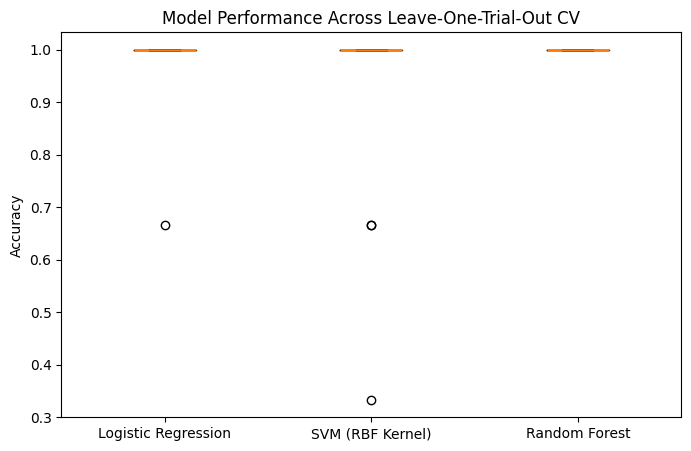

In [69]:
# --- Plot boxplots ---
plt.figure(figsize=(8,5))
plt.boxplot(cv_results.values(), tick_labels=cv_results.keys())
plt.ylabel("Accuracy")
plt.title("Model Performance Across Leave-One-Trial-Out CV")
plt.show()

## TRAIN / TEST SPLIT + SCALING

In [70]:
# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [71]:
# 2. Train + Evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Test Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Test Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Confusion Matrix:
 [[4 0 0]
 [0 4 0]
 [0 0 4]]

SVM (RBF Kernel) Test Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Confusion Matrix:
 [[4 0 0]
 [0 4 0]
 [0 0 4]]

Random Forest Test Results:
              precision    recall  f1-score   su

# EXPLORATORY ANALYSIS/ VISUALIZATION


## CONFUSION MATRIX

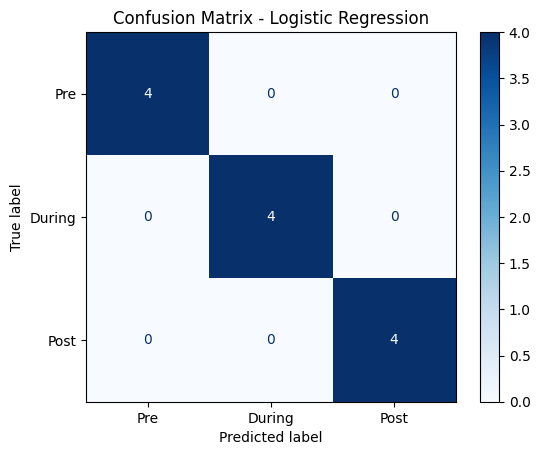

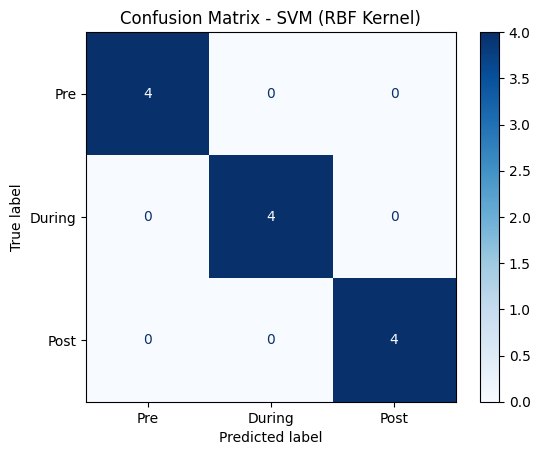

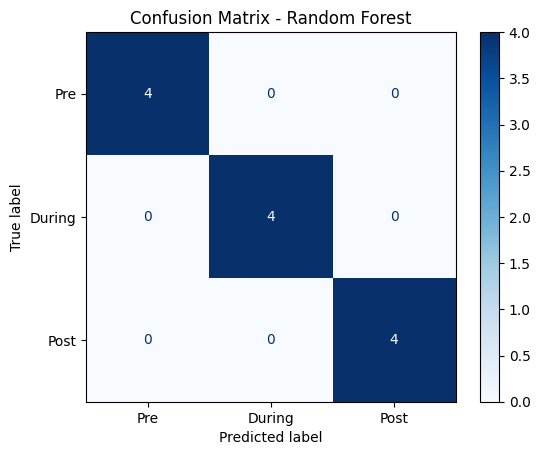

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=["Pre", "During", "Post"],
        cmap="Blues", values_format="d"
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

## ROC CURVE

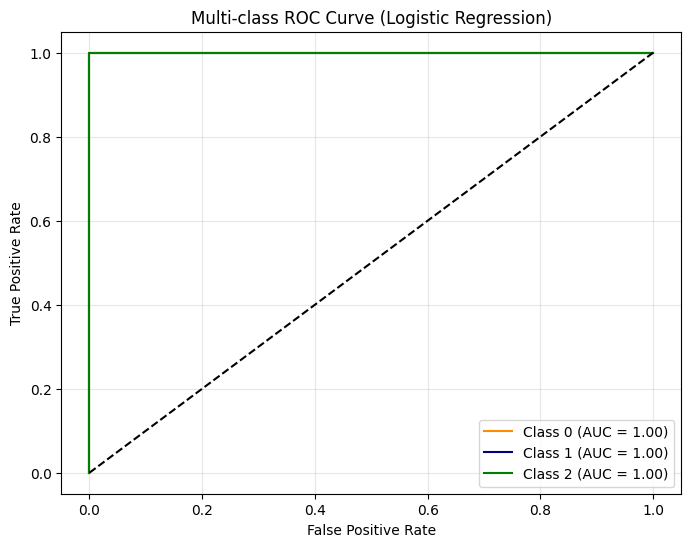

In [75]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Pick one model (e.g., Logistic Regression)
clf = models["Logistic Regression"]
y_score = clf.predict_proba(X_test)

# Binarize labels
y_test_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test_bin.shape[1]

# Compute ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
colors = cycle(["darkorange", "navy", "green"])
plt.figure(figsize=(8,6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (Logistic Regression)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



## CLOSED LOOP EXPERIMENT EXECUTOR using PyTES (SPRINT2)

from
- MiSO
    - https://github.com/yuumii-san/MiSO/blob/main/py/closed_loop_experiment_executor.py#L25
  
- ElsevierSoftwareX
    - https://github.com/ElsevierSoftwareX/SOFTX-D-22-00212

__why use PyTes?__

Its an open source framework designed for closed loop tES experiments

Even though the prototype focuses on EEG preprocessng and decision making. PyTES provides a structured way to connect those decisions to actual stimulation hardware.

By Using it as reference we ensure our prototype can be extended to real hardware in the future.

We mock the stimulation commands but align it with pyTES to make our pipeline closer to a deployable closed loop system
  

In [ ]:
# # clone PyTES
# !pip install git+https://github.com/TateXu/pytes.git

In [ ]:
#clone and install if pip fails:
# git clone https://github.com/TateXu/pytes.git
# cd pytes
# pip install

In [ ]:
# import pickle
# import copy
# import sys
# import time

# # sys.path.append("./util/")
# # from fa import factor_analysis as fa_mdl
# # from spike_data_generator import generate_spike_count_data
# # from fa_trainer import fit_fa
# # from fa_loading_aligner import align_loadings

# def run_closed_loop_experiment(eeg_features,labels = None, num_trials = 100,alpha_threshold = 0.5 ):
#     """
#     Run a closed loop experiment with MiSO

#     Parameters:
#         config_path_closed_loop(str): Path to the closed loop configuration file
#         config_path-mne(str) : Path to the mne configuration file
#         config_path_band_power(str) : Path to the band power features configuration file
#         filename_ref( list of str): List of reference session file name
#         filename_test (list of str): List of test session file name

#     Returns:
#         dict: closed loop experiment performance summary
#     """

#     print('Load closed-loop experiment config')
#     with open(config_path_closed_loop, 'r') as f:
#         config_closed_loop = yaml.safe_load(f)

#     input_path_base = config_closed_loop['input'].get('input_path_base', './')
#     prediction_filename = config_closed_loop['prediction'].get('prediction_fikename', '')
#     target = config_closed_loop['closed_loop'].get('target',[0,0])
#     target_dimension = config_closed_loop['closed_loop'].get('target_dimension',[0,1])
#     bin_size_ms = config_closed_loop['closed_loop'].get('bin_size_ms', 50)
#     lr = config_closed_loop['closed_loop'].get('lr', 0.1)
#     num_trials = config_closed_loop['closed_loop'].get('num_trials', 1000)
#     epsilon = config_closed_loop['closed_loop'].get('epsilon', 0.05)

#     # load test firing rate data
#     fr_test_df = np.loadtxt(f".../data/fr/fr_{filename_test[0]}.csv", delimiter=',')

#     print('Generate EEG count data for calibration')
#     generate


simulator states - on/off

simulator parameters - frequency , amplitude


In [ ]:
# class SignalGenerator:
#     def __init_(self):
#         #below is a dictionary to hold the settings
#         self.state = "OFF"
#         self.parameters = {"amplitude":None, "frequency": None}

#     #methods that change the state
#     def on (self, amplitude, frequency):
#         #change self state to ON
#         self.state = "ON"
#         #update parameters
#         self.parameters ["frequency"] = frequency
#         self.parameters["amplitude"] = amplitude
#         print(f"[stimulator ON] frequency = {frequency}Hz amplitude = {amplitude}V")

#     #methods that stop the state
#     def off(self, set_amplitude, set_frequency):
#         self.state = "OFF"
#         self.parameters = {"amplitude":0, "frequency": 0}
#         print(f"[stimulator OFF] frequency = {frequency}Hz amplitude = {amplitude}V")

#     def amp(self, value):
#         self.set_parameters("amplitude", value)

#     def frequency(self, value):
#         self.set_parameters("frequency", value)

#     def phase(self, value):
#         self.set_parameters("phase", value)

#     def offset(self, value):
#         self.set_parameters("offset", value)

#     def fade(self, amplitude = 0.5, fade_duration =5, step_per_second = 2, fademode = 'in'):
#         """
#         simulate fade-in/ out by gradually changing amplitude
#         """

#         sleep_duration = 1 / step_per_second
#         step_list = np.linspace(0.002, amplitude, int(fade_duration * step_per_second))

#         if fademode == 'in':
#             for stimulation_value  in step_list:
#                 self.amplitude(stimulation_value)
#                 time.sleep(sleep_duration)
#         elif fademode == 'out':
#             for stimulation_value in step_list[::-1]:
#                 self.amplitude(stimulation_value)
#                 time.sleep(sleep_duration)

# print(f"[Stimulator] Fade {fademode} completed")

## Why include the above functions?

- we need a virtual stimulator for our closed loop prototype

- the functions amplitude, frequency, phase and offset let us control the stimulation parameters in a way that looks like real hardware control but in practise just updates internal variables

EEG -> feature extraction -> decision logic -> stimulator API

__AMPLITUDE FUNCTION__

controls the amplitude of the stimulation signal.

Amplitude determines the strength of the stimulation which can affect brain oscilllations are entrained.

amplitude is the voltage delivered in tES

- 0.5 voltage is weak stimulation
  
- 1.0 voltage is stronger

we store this number in a dictionary to stimulate turning up or down the stimulator

__FREQUENCY FUNCTION__

Controls the frequency of the stimulation waveform.

EEG bands (alpha, beta, theta) are defined by frequency. If alpha power is low, we might stimulate at 10 Hz (alpha range) to boost it.

In real tACS: setting 10 Hz means the device outputs a 10 Hz sine wave.

In prototype: just logs or stores that frequency value

__PHASE FUNCTION__

Adjusts the phase (timing shift) of the waveform.

Phase-aligned stimulation can maximize entrainment (synchronization between brain rhythms and external current).

In real tES: phase shifts are used in research to align stimulation with the brain’s oscillations.

In prototype: just stores/logs a phase offset (e.g., 0°, 90°).


__OFFSET FUNCTION__

Sets a DC offset (baseline shift of the waveform).

DC offset is used for non-oscillatory stimulation (tDCS mode), influencing cortical excitability.

In real tDCS: this corresponds to steady current delivery without oscillations.

In prototype: just saves the offset value.


__FADE FUNCTION__

Simulates a smooth ramping in or out of stimulation.

This mirrors real safety procedures in brain stimulation — ramping avoids shocks/tingling.

Instead of instantly switching from 0 V to 1 V (which can feel uncomfortable for real subjects), it gradually increases the amplitude over a few seconds.

In our prototype: it just prints/logs increasing steps (0.1, 0.2, 0.3… until 1.0).



In [ ]:
# stimulator =
# #are we only checking alpha poower?
# if alpha_power < threshold:
#     stimulator.on(frequency = 10, amplitude = 0.8)
# else:
#     stimulator.off()